In [1]:
# load npz 
import numpy as np
front_path = '/workspace/data/sam3d_body_results/19/夜多い/front/000000_sam3d_body.npz'
left_path = '/workspace/data/sam3d_body_results/19/夜多い/left/000000_sam3d_body.npz'
right_path = '/workspace/data/sam3d_body_results/19/夜多い/right/000000_sam3d_body.npz'

front_data = np.load(front_path, allow_pickle=True)
left_data = np.load(left_path, allow_pickle=True)
right_data = np.load(right_path, allow_pickle=True)

In [2]:
front_info = front_data['output'].item()
left_info = left_data['output'].item()
right_info = right_data['output'].item()

print("front_info:", front_info.keys())
print("left_info:", left_info.keys())
print("right_info:", right_info.keys())

front_info: dict_keys(['bbox', 'focal_length', 'pred_keypoints_3d', 'pred_keypoints_2d', 'pred_vertices', 'pred_cam_t', 'pred_pose_raw', 'global_rot', 'body_pose_params', 'hand_pose_params', 'scale_params', 'shape_params', 'expr_params', 'mask', 'pred_joint_coords', 'pred_global_rots', 'mhr_model_params', 'lhand_bbox', 'rhand_bbox', 'frame', 'frame_idx'])
left_info: dict_keys(['bbox', 'focal_length', 'pred_keypoints_3d', 'pred_keypoints_2d', 'pred_vertices', 'pred_cam_t', 'pred_pose_raw', 'global_rot', 'body_pose_params', 'hand_pose_params', 'scale_params', 'shape_params', 'expr_params', 'mask', 'pred_joint_coords', 'pred_global_rots', 'mhr_model_params', 'lhand_bbox', 'rhand_bbox', 'frame', 'frame_idx'])
right_info: dict_keys(['bbox', 'focal_length', 'pred_keypoints_3d', 'pred_keypoints_2d', 'pred_vertices', 'pred_cam_t', 'pred_pose_raw', 'global_rot', 'body_pose_params', 'hand_pose_params', 'scale_params', 'shape_params', 'expr_params', 'mask', 'pred_joint_coords', 'pred_global_rots'

In [3]:
for k, v in front_info.items():
    print(f"front_info[{k}]: {type(v)}")

front_info[bbox]: <class 'numpy.ndarray'>
front_info[focal_length]: <class 'numpy.float32'>
front_info[pred_keypoints_3d]: <class 'numpy.ndarray'>
front_info[pred_keypoints_2d]: <class 'numpy.ndarray'>
front_info[pred_vertices]: <class 'numpy.ndarray'>
front_info[pred_cam_t]: <class 'numpy.ndarray'>
front_info[pred_pose_raw]: <class 'numpy.ndarray'>
front_info[global_rot]: <class 'numpy.ndarray'>
front_info[body_pose_params]: <class 'numpy.ndarray'>
front_info[hand_pose_params]: <class 'numpy.ndarray'>
front_info[scale_params]: <class 'numpy.ndarray'>
front_info[shape_params]: <class 'numpy.ndarray'>
front_info[expr_params]: <class 'numpy.ndarray'>
front_info[mask]: <class 'NoneType'>
front_info[pred_joint_coords]: <class 'numpy.ndarray'>
front_info[pred_global_rots]: <class 'numpy.ndarray'>
front_info[mhr_model_params]: <class 'numpy.ndarray'>
front_info[lhand_bbox]: <class 'numpy.ndarray'>
front_info[rhand_bbox]: <class 'numpy.ndarray'>
front_info[frame]: <class 'numpy.ndarray'>
fron

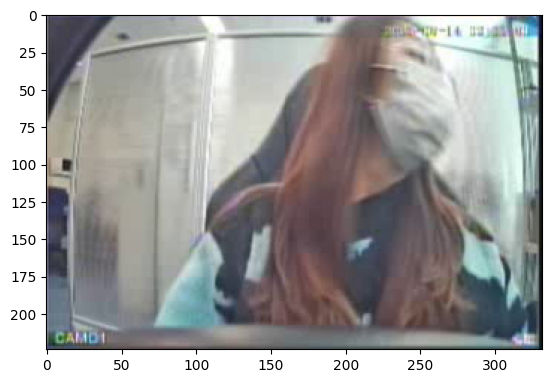

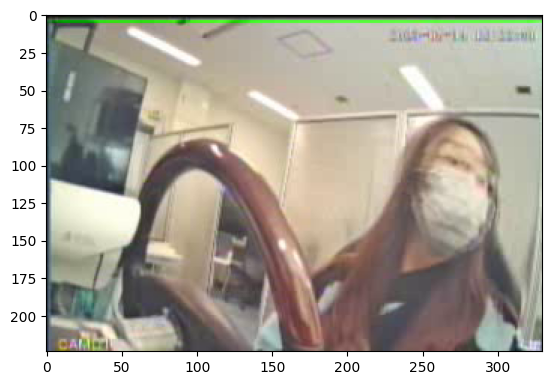

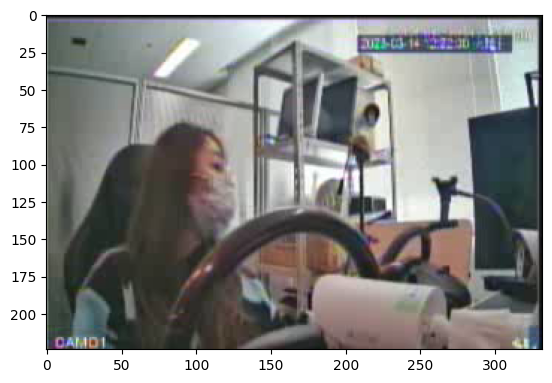

In [4]:
import matplotlib.pyplot as plt
plt.imshow(front_info['frame'])
plt.show()
plt.imshow(left_info['frame'])
plt.show()
plt.imshow(right_info['frame'])
plt.show()

In [5]:
# 过滤头部的关键点
left_3d_keypoints = left_info['pred_keypoints_3d']
right_3d_keypoints = right_info['pred_keypoints_3d']
front_3d_keypoints = front_info['pred_keypoints_3d']

left_3d_keypoints.shape, right_3d_keypoints.shape, front_3d_keypoints.shape

((70, 3), (70, 3), (70, 3))

In [6]:
import numpy as np

# ---- MHR70 index groups ----
HEAD_IDX = np.array([0, 1, 2, 3, 4], dtype=int)
NECK_IDX = np.array([69], dtype=int)

RIGHT_HAND_IDX = np.arange(21, 42)  # 21..41
LEFT_HAND_IDX  = np.arange(42, 63)  # 42..62
HANDS_IDX = np.concatenate([RIGHT_HAND_IDX, LEFT_HAND_IDX])



In [7]:
import numpy as np

# ---- MHR70 index groups ----
HEAD_IDX = np.array([0, 1, 2, 3, 4], dtype=int)
NECK_IDX = np.array([69], dtype=int)

RIGHT_HAND_IDX = np.arange(21, 42)  # 21..41
LEFT_HAND_IDX  = np.arange(42, 63)  # 42..62
HANDS_IDX = np.concatenate([RIGHT_HAND_IDX, LEFT_HAND_IDX])

HEAD_SHOULDER_IDX = np.array([
    0,   # nose
    1,   # left_eye
    2,   # right_eye
    3,   # left_ear
    4,   # right_ear
    69,  # neck
    5,   # left_shoulder
    6,   # right_shoulder
], dtype=int)

def keep_and_filter_kpts_no_conf(
    kpts: np.ndarray,
    keep_idx: np.ndarray,
    image_size: tuple[int, int] | None = None,
    zero_eps: float = 1e-6,
):
    """
    Keep only keep_idx joints (others -> 0), and filter invalid joints without conf.

    Args:
        kpts: (..., 70, D)  D=2 or 3
        keep_idx: (K,) indices to keep
        image_size: (H,W) optional, for 2D bounds check
    Returns:
        kpts_out: (..., 70, D)  (non-kept or invalid -> 0)
        mask_out: (..., 70) bool  (True = kept & valid)
    """
    kpts = np.asarray(kpts)
    assert kpts.shape[-2] == 70, f"Expect 70 kpts, got {kpts.shape}"

    keep_idx = np.asarray(keep_idx, dtype=int)
    keep_mask = np.zeros(kpts.shape[-2], dtype=bool)
    keep_mask[keep_idx] = True  # (70,)

    # validity mask (no conf)
    valid = np.isfinite(kpts).all(axis=-1)                       # (...,70)
    valid &= (np.linalg.norm(kpts, axis=-1) >= zero_eps)         # remove all-zero

    if image_size is not None and kpts.shape[-1] >= 2:
        H, W = image_size
        x, y = kpts[..., 0], kpts[..., 1]
        valid &= (x >= 0) & (x < W) & (y >= 0) & (y < H)

    # only keep selected joints
    mask_out = valid & keep_mask  # broadcasting keep_mask -> (...,70)

    kpts_out = np.zeros_like(kpts)
    kpts_out[mask_out] = kpts[mask_out]

    return kpts_out, mask_out

In [8]:
def filter_three_views_keep_no_conf(
    kpts_by_view: dict,
    keep_idx: np.ndarray,
    image_size_by_view: dict | None = None,
    zero_eps: float = 1e-6,
):
    """
    kpts_by_view: {"front":(...,70,D), "left":..., "right":...}
    returns:
      kpts_out_by_view, mask_out_by_view
    """
    out_k, out_m = {}, {}
    for v in ("front", "left", "right"):
        kpts = kpts_by_view[v]
        imsz = None if image_size_by_view is None else image_size_by_view.get(v, None)
        ko, mo = keep_and_filter_kpts_no_conf(
            kpts, keep_idx=keep_idx, image_size=imsz, zero_eps=zero_eps
        )
        out_k[v] = ko
        out_m[v] = mo
    return out_k, out_m

keep_idx = HEAD_SHOULDER_IDX
k_out, m_out = filter_three_views_keep_no_conf(
    {"front": front_3d_keypoints, "left": left_3d_keypoints, "right": right_3d_keypoints},
    keep_idx=keep_idx
)

In [9]:
for k, v in k_out.items():
    print(f"k_out[{k}].shape: {v.shape}")

k_out[front].shape: (70, 3)
k_out[left].shape: (70, 3)
k_out[right].shape: (70, 3)


In [10]:
import numpy as np

def fuse_3view_kpts_ignore_zero(
    k_front: np.ndarray,
    k_left: np.ndarray,
    k_right: np.ndarray,
    method: str = "mean",     # "mean" or "median" or "first"
    zero_eps: float = 1e-6,
    fill_value: float = np.nan,  # 缺失时填 NaN（推荐），也可以填 0.0
):
    """
    Fuse 3-view 3D keypoints into one (70,3) by ignoring invalid (near-zero) joints.

    Args:
        k_front/k_left/k_right: (70,3)
        method:
          - "mean": 对有效视角取均值（默认）
          - "median": 对有效视角取中位数（更抗离群）
          - "first": 取 front->left->right 中第一个有效值（最快）
        zero_eps: norm < zero_eps 认为是无效点（比如(0,0,0)）
        fill_value: 当三视角都无效时的填充值（NaN 推荐）
    Returns:
        fused: (70,3)
        fused_mask: (70,) True 表示该关节至少有一个视角有效
        n_valid: (70,) 每个关节有效视角数量（0~3）
    """
    K = np.stack([k_front, k_left, k_right], axis=0).astype(np.float64)  # (3,70,3)

    # 有效判定：finite 且 不是全零（或近零）
    finite = np.isfinite(K).all(axis=-1)            # (3,70)
    nonzero = np.linalg.norm(K, axis=-1) >= zero_eps  # (3,70)
    valid = finite & nonzero                         # (3,70)

    fused_mask = valid.any(axis=0)                   # (70,)
    n_valid = valid.sum(axis=0).astype(np.int64)     # (70,)

    fused = np.full((70, 3), fill_value, dtype=np.float64)

    if method == "first":
        # front -> left -> right
        for j in range(70):
            for v in range(3):
                if valid[v, j]:
                    fused[j] = K[v, j]
                    break

    elif method in ("mean", "median"):
        # 把无效值置为 NaN，然后按 view 维度做 nanmean/nanmedian
        K2 = K.copy()
        K2[~valid] = np.nan

        if method == "mean":
            fused[fused_mask] = np.nanmean(K2[:, fused_mask, :], axis=0)
        else:
            fused[fused_mask] = np.nanmedian(K2[:, fused_mask, :], axis=0)

    else:
        raise ValueError("method must be one of: 'mean', 'median', 'first'")

    return fused, fused_mask, n_valid

In [11]:
fused, fused_mask, n_valid = fuse_3view_kpts_ignore_zero(
    k_out["front"], k_out["left"], k_out["right"],
    method="median",     # 推荐 median 更稳
    fill_value=np.nan,   # 推荐 NaN 标记缺失
)
print(fused.shape)       # (70,3)
print(n_valid[:10])      # 每个关节有几个视角有效

(70, 3)
[3 3 3 3 3 3 3 0 0 0]


In [12]:
fused.shape

(70, 3)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 你可以直接用这份边（来自你贴的 skeleton_info，转成 idx）
MHR70_NAME2IDX = {
    "nose": 0, "left_eye": 1, "right_eye": 2, "left_ear": 3, "right_ear": 4,
    "left_shoulder": 5, "right_shoulder": 6, "left_elbow": 7, "right_elbow": 8,
    "left_hip": 9, "right_hip": 10, "left_knee": 11, "right_knee": 12,
    "left_ankle": 13, "right_ankle": 14,
    "left_big_toe": 15, "left_small_toe": 16, "left_heel": 17,
    "right_big_toe": 18, "right_small_toe": 19, "right_heel": 20,
    "right_wrist": 41, "left_wrist": 62, "neck": 69,
    # 手指等如果你要连也可以继续补（你现在 skeleton_info 里已经写了很多）
}

# skeleton_info 的 link（我只放你贴出来的一部分：身体+头；手指边你也可以继续加）
MHR70_EDGES = [
    (13, 11), (11, 9),          # left_ankle-left_knee, left_knee-left_hip
    (14, 12), (12, 10),         # right_ankle-right_knee, right_knee-right_hip
    (9, 10),                    # left_hip-right_hip
    (5, 9), (6, 10),            # shoulders to hips
    (5, 6),                     # shoulder-shoulder
    (5, 7), (6, 8),             # shoulder-elbow
    (7, 62), (8, 41),           # elbow-wrist (注意：left_wrist=62, right_wrist=41)
    (1, 2), (0, 1), (0, 2),     # eye-eye, nose-eye
    (1, 3), (2, 4),             # eye-ear
    (3, 5), (4, 6),             # ear-shoulder
]

def _valid_mask(kpts: np.ndarray, zero_eps: float = 1e-6):
    kpts = np.asarray(kpts, dtype=np.float64)
    finite = np.isfinite(kpts).all(axis=-1)
    nonzero = np.linalg.norm(kpts, axis=-1) >= zero_eps
    return finite & nonzero  # (70,)

def plot_kpts3d(
    kpts: np.ndarray,
    edges=MHR70_EDGES,
    title: str = "",
    zero_eps: float = 1e-6,
    show_axis: bool = True,
    elev: float = 15,
    azim: float = -70,
):
    """
    kpts: (70,3)  (invalid can be 0 or NaN)
    """
    kpts = np.asarray(kpts, dtype=np.float64)
    assert kpts.shape == (70, 3), f"Expect (70,3), got {kpts.shape}"

    mask = _valid_mask(kpts, zero_eps=zero_eps)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title)

    # scatter valid points
    P = kpts[mask]
    if P.shape[0] > 0:
        ax.scatter(P[:, 0], P[:, 1], P[:, 2], s=15)

    # skeleton lines (only draw if both ends valid)
    for (i, j) in edges:
        if mask[i] and mask[j]:
            xs = [kpts[i, 0], kpts[j, 0]]
            ys = [kpts[i, 1], kpts[j, 1]]
            zs = [kpts[i, 2], kpts[j, 2]]
            ax.plot(xs, ys, zs, linewidth=1.0)

    # equal-ish aspect
    if P.shape[0] > 0:
        mins = P.min(axis=0)
        maxs = P.max(axis=0)
        center = (mins + maxs) / 2
        radius = (maxs - mins).max() / 2 + 1e-9
        ax.set_xlim(center[0] - radius, center[0] + radius)
        ax.set_ylim(center[1] - radius, center[1] + radius)
        ax.set_zlim(center[2] - radius, center[2] + radius)

    if not show_axis:
        ax.set_axis_off()

    plt.show()
    return fig, ax

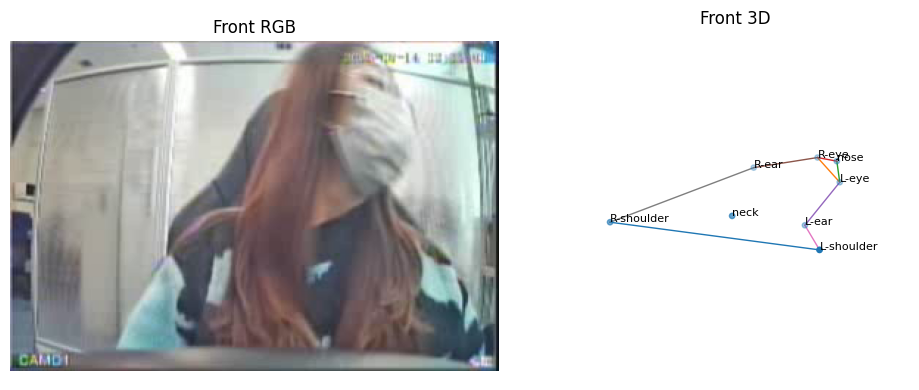

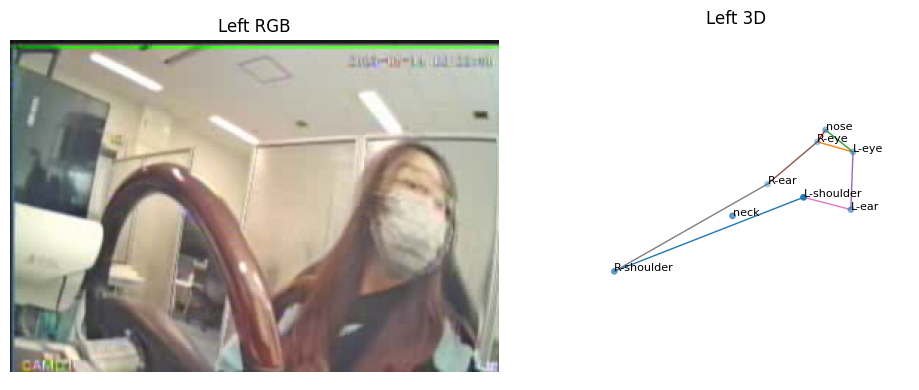

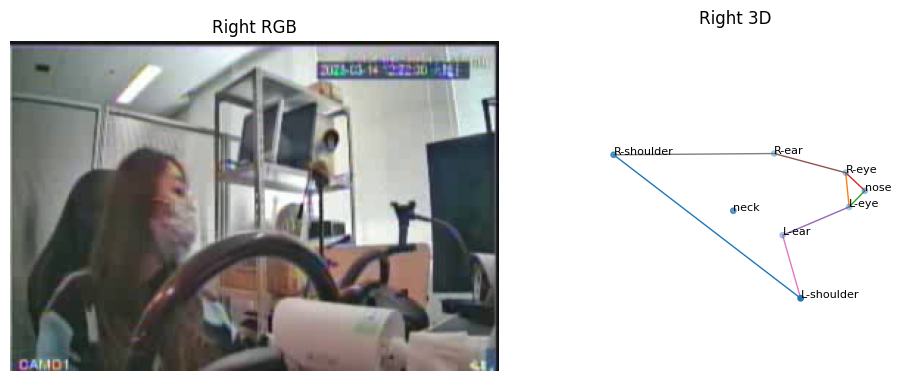

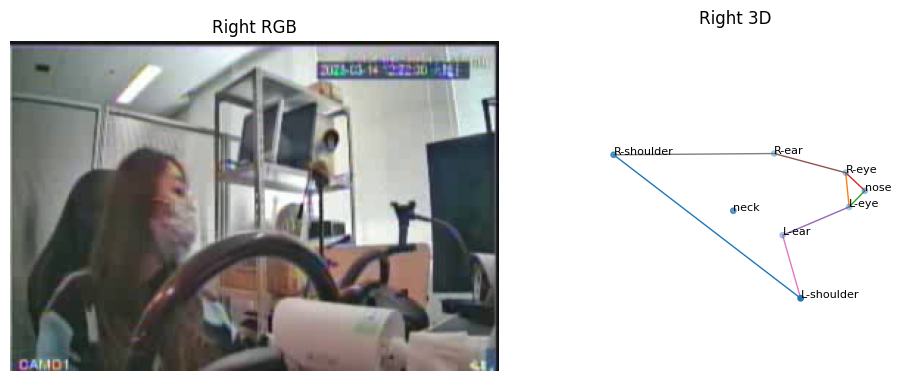

In [14]:
MHR70_IDX2NAME = {
    0: "nose",
    1: "L-eye",
    2: "R-eye",
    3: "L-ear",
    4: "R-ear",
    5: "L-shoulder",
    6: "R-shoulder",
    7: "L-elbow",
    8: "R-elbow",
    9: "L-hip",
    10: "R-hip",
    11: "L-knee",
    12: "R-knee",
    13: "L-ankle",
    14: "R-ankle",
    41: "R-wrist",
    62: "L-wrist",
    69: "neck",
}

def plot_image_and_kpts3d(
    img: np.ndarray,
    kpts: np.ndarray,
    edges=MHR70_EDGES,
    title_img: str = "RGB",
    title_3d: str = "3D Keypoints",
    zero_eps: float = 1e-6,
    elev: float = 15,
    azim: float = -70,
    show_axis: bool = False,
    show_labels: bool = True,          # 新增
    label_dict: dict | None = None,     # 新增
):
    assert kpts.shape == (70, 3)
    assert img.ndim == 3

    # 需要把sam 3d坐标系转成常用的右手坐标系
    # TODO：这个还需要调整， 现在方向还是不对的
    # 反转x轴
    # kpts[:, 0] = -kpts[:, 0]
    # 反转y轴
    kpts[:, 1] = -kpts[:, 1]
    # 反转z轴
    kpts[:, 2] = -kpts[:, 2]

    mask = _valid_mask(kpts, zero_eps=zero_eps)

    fig = plt.figure(figsize=(10, 4))

    # ---- left: RGB ----
    ax_img = fig.add_subplot(1, 2, 1)
    ax_img.imshow(img)
    ax_img.set_title(title_img)
    ax_img.axis("off")

    # ---- right: 3D ----
    ax3d = fig.add_subplot(1, 2, 2, projection="3d")
    ax3d.view_init(elev=elev, azim=azim)
    ax3d.set_title(title_3d)
    ax3d.axis("equal")

    # scatter
    P = kpts[mask]
    if P.shape[0] > 0:
        ax3d.scatter(P[:, 0], P[:, 1], P[:, 2], s=15)

    # skeleton edges
    for (i, j) in edges:
        if mask[i] and mask[j]:
            ax3d.plot(
                [kpts[i, 0], kpts[j, 0]],
                [kpts[i, 1], kpts[j, 1]],
                [kpts[i, 2], kpts[j, 2]],
                linewidth=1.0,
            )

    # ---------- 新增：关节点文字 ----------
    if show_labels:
        for idx in range(70):
            if not mask[idx]:
                continue
            name = str(idx)
            if label_dict is not None and idx in label_dict:
                name = label_dict[idx]
            ax3d.text(
                kpts[idx, 0],
                kpts[idx, 1],
                kpts[idx, 2],
                name,
                fontsize=8,
            )

    # equal aspect
    if P.shape[0] > 0:
        mins = P.min(axis=0)
        maxs = P.max(axis=0)
        center = (mins + maxs) / 2
        radius = (maxs - mins).max() / 2 + 1e-9
        ax3d.set_xlim(center[0] - radius, center[0] + radius)
        ax3d.set_ylim(center[1] - radius, center[1] + radius)
        ax3d.set_zlim(center[2] - radius, center[2] + radius)

    if not show_axis:
        ax3d.set_axis_off()

    plt.tight_layout()
    plt.show()
    return fig

plot_image_and_kpts3d(
    front_info["frame"],
    k_out["front"],
    title_img="Front RGB",
    title_3d="Front 3D",
    show_labels=True,
    label_dict=MHR70_IDX2NAME,
)
plot_image_and_kpts3d(
    left_info["frame"],
    k_out["left"],
    title_img="Left RGB",
    title_3d="Left 3D",
    show_labels=True,
    label_dict=MHR70_IDX2NAME,
)
plot_image_and_kpts3d(
    right_info["frame"],
    k_out["right"],
    title_img="Right RGB",
    title_3d="Right 3D",
    show_labels=True,
    label_dict=MHR70_IDX2NAME,
)